#### 공사비의 공사번호 기준 설비 카운팅

##### 카운팅 후 불필요 레코드 제거
* 전선: 0 또는 11개 이상
* 전주: 0 또는 10개 이상

In [16]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.aiddd.data_manager import read_data, write_data

# 한글처리 지원
plt_settings()

In [17]:
MIN_POLE_LINE_COUNTS = 2

#### 데이터 불러오기

In [18]:
_start = datetime.now()

# 제공받은 설비 데이터
provided_data = {
    'line': read_data('LINE_DATA', 'provide'),
    'pole': read_data('POLE_DATA', 'provide'),
    'sl': read_data('SL_DATA', 'provide')
}

# 전처리된 공사비 데이터
df_cons = read_data('ba-cons')

print(
    f'Total Elapsed Time for Data Load: {datetime.now() - _start}\n'
    'Provided Data Shape:', end=' '
)
for data_key in provided_data.keys():
    print(f'{data_key} {provided_data[data_key].shape}', end=', ')
print(f'\nPreprocessing Data Shape: {df_cons.shape}')

Total Elapsed Time for Data Load: 0:00:48.002496
Provided Data Shape: line (40019, 77), pole (38533, 63), sl (22632, 57), 
Preprocessing Data Shape: (15335, 15)


#### 공사번호별 설비들(전선/전주/인입선) 갯 수 계산

In [19]:
# nodpcn: number of devices per construction number(공사번호별 장치 갯 수)
# cnts: counts
for data_key in provided_data.keys():
    series_nodpcn = provided_data[data_key]['공사번호'].value_counts()
    column_name = f'{data_key}_cnts'
    df_cons = pd.merge(
        df_cons, series_nodpcn.rename(column_name),
        left_on='cons_no', right_on=series_nodpcn.index,
        how='left'
    )
    # 장치 갯 수가 없는 공사번호는 np.NaN이 들어가는데, 이 값을 0으로 변경
    df_cons[column_name].fillna(0, inplace=True)
    # 정수값으로 변경
    df_cons[column_name] = df_cons[column_name].astype(int)

#### 불필요 레코드 제거

In [20]:
# 유지할 조건 
training_data_conditions = \
    (df_cons['pole_cnts'] >= MIN_POLE_LINE_COUNTS) & (df_cons['pole_cnts'] <= 10) & \
    (df_cons['line_cnts'] >= MIN_POLE_LINE_COUNTS) & (df_cons['line_cnts'] <= 11)
    
# 불필요(제거)할 레코드 카운트 확인
df_cons[~training_data_conditions].shape

(9625, 18)

In [21]:
# 768개면 예외로 무시 가능하기 때문에 제거
df_training = df_cons[training_data_conditions]

In [22]:
# 이 두 공사번호에서 다른 위치의 같은 전산화번호를 쓰는 전주를 관리하기 때문에,
# 전주1, 전선1, 인입선1게 있는 474920213966 삭제
df_training[df_training.cons_no.isin(['474920213231', '474920213966'])]

,cons_no,total_cons_cost,cont_cap,last_mod_date,year,month,day,dayofweek,dayofyear,last_mod_eid,eid_code,eid_code_num,eid_num,office_name,office_num,line_cnts,pole_cnts,sl_cnts
8191,474920213231,3261098,3,2021-03-19 08:37:34,2021,3,19,4,78,2019108601,AAA,1,2019108601,제천지사,7,2,2,1


In [23]:
df_training = df_training[df_training.cons_no != '474920213966']

In [24]:
# 불필요 레코드가 제거된 학습용 전처리 데이터
filename = 'bb-device-counts' if MIN_POLE_LINE_COUNTS == 1 else 'bb-device-counts-2'
write_data(filename, df_training)
# 불필요 레코드가 포함된 전처리 데이터
write_data('bb-device-counts-all', df_cons)

#### 차트로 확인

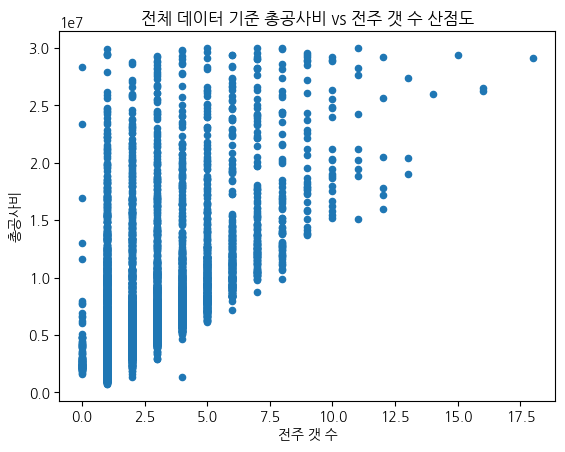

In [25]:
df_cons.plot.scatter(x='pole_cnts', y='total_cons_cost')
plt.xlabel('전주 갯 수')
plt.ylabel('총공사비')
plt.title('전체 데이터 기준 총공사비 vs 전주 갯 수 산점도')
plt.show()

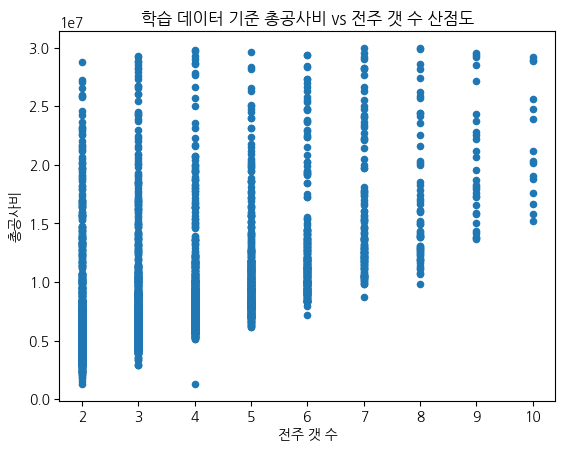

In [26]:
df_training.plot.scatter(x='pole_cnts', y='total_cons_cost')
plt.xlabel('전주 갯 수')
plt.ylabel('총공사비')
plt.title('학습 데이터 기준 총공사비 vs 전주 갯 수 산점도')
plt.show()

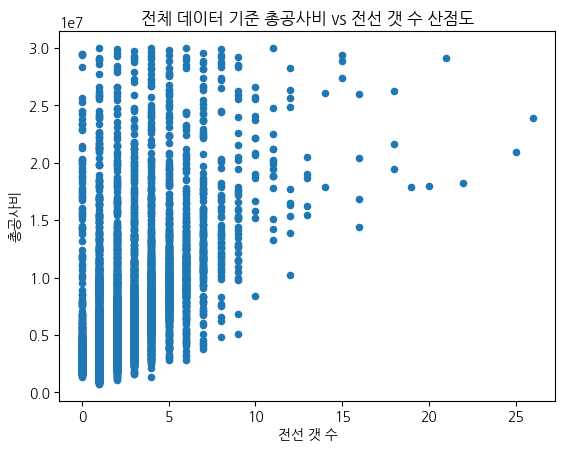

In [27]:
df_cons.plot.scatter(x='line_cnts', y='total_cons_cost')
plt.xlabel('전선 갯 수')
plt.ylabel('총공사비')
plt.title('전체 데이터 기준 총공사비 vs 전선 갯 수 산점도')
plt.show()

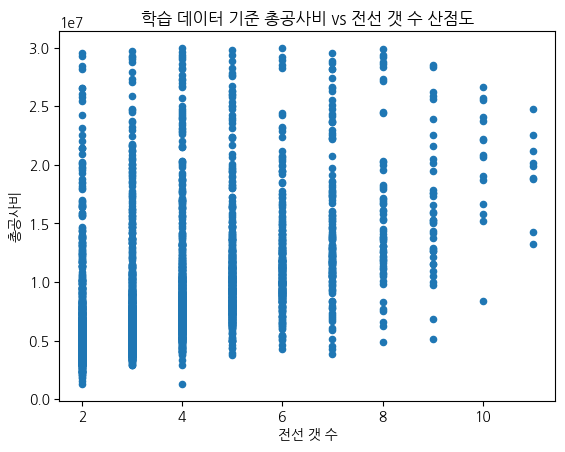

In [28]:
df_training.plot.scatter(x='line_cnts', y='total_cons_cost')
plt.xlabel('전선 갯 수')
plt.ylabel('총공사비')
plt.title('학습 데이터 기준 총공사비 vs 전선 갯 수 산점도')
plt.show()

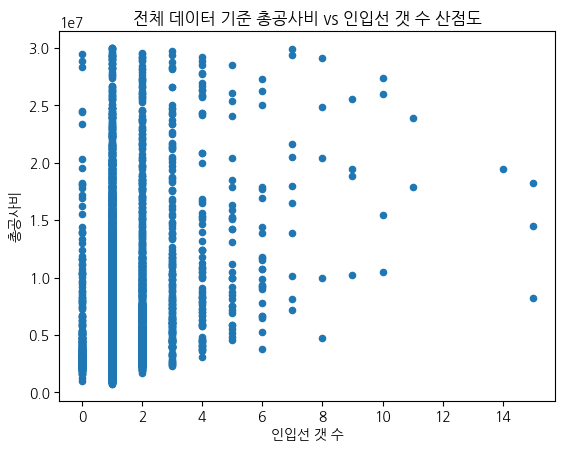

In [29]:
df_cons.plot.scatter(x='sl_cnts', y='total_cons_cost')
plt.xlabel('인입선 갯 수')
plt.ylabel('총공사비')
plt.title('전체 데이터 기준 총공사비 vs 인입선 갯 수 산점도')
plt.show()

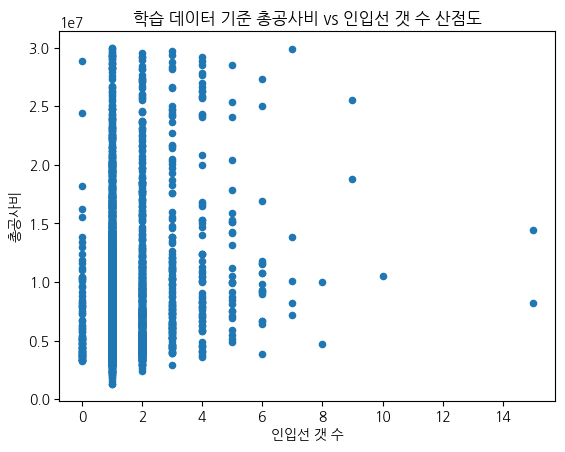

In [30]:
df_training.plot.scatter(x='sl_cnts', y='total_cons_cost')
plt.xlabel('인입선 갯 수')
plt.ylabel('총공사비')
plt.title('학습 데이터 기준 총공사비 vs 인입선 갯 수 산점도')
plt.show()